In [1]:
import re
import string
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score(prediction, ground_truth):
    common = Counter(prediction) & Counter(ground_truth)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction)
    recall = 1.0 * num_same / len(ground_truth)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def qa_f1_score(prediction, ground_truth):
    normalized_prediction = normalize_answer(prediction)
    normalized_ground_truth = normalize_answer(ground_truth)

    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    return f1_score(prediction_tokens, ground_truth_tokens)

In [3]:
percentages = [50, 60, 70]
summ_metrics_df = pd.DataFrame(columns=['Compression (%)', 'F1', 'Latency (s)', 'memory_usage', 'Peak Memory (MB)'])

for i in percentages:
    df1 = pd.read_csv(f"summarization_model_experiment/summarize_{i}.csv")
    df2 = pd.read_json(f"summarization_model_experiment/metrics_{i}.json")
    df = df1.merge(df2, how='inner', on='_id')
    df['answers'] = df['answers'].apply(lambda x: x[2:-2])
    f1_scores = []
    for idx, row in df.iterrows():
        f1_scores.append(qa_f1_score(row['responses'], row['answers']))
    df['f1_scores'] = f1_scores
    metric = [i]
    metric.extend(list(df[['f1_scores', 'latencies', 'memory_usages', 'peak_memory_usages']].mean()))
    summ_metrics_df.loc[len(summ_metrics_df)] = metric

print(summ_metrics_df)

   Compression (%)        F1  Latency (s)  memory_usage  Peak Memory (MB)
0             50.0  0.279976     0.994257  11944.816895      12622.176875
1             60.0  0.310291     1.154898  11944.816895      12747.715146
2             70.0  0.295423     1.383002  11944.816895      12873.499131


In [4]:
llmlingua_data = {
    "Compression (%)": [50, 60, 70],
    "F1": [0.20, 0.23, 0.28],
    "Latency (s)": [1.13, 1.30, 1.41],
    "Peak Memory (MB)": [12340.50, 12470.63, 12745.41]
}

random_token_pruning_data = {
    "Compression (%)": [50, 60, 70],
    "F1": [0.22, 0.26, 0.31],
    "Latency (s)": [1.49, 1.49, 1.62],
    "Peak Memory (MB)": [12600.22, 12731.72, 12863.38]
}

no_pruning_data = {
    "Compression (%)": "Full Context",
    "F1": 0.44,
    "Latency (s)": 2.16,
    "Peak Memory (MB)": 13264.43
}

# Create DataFrames
llmlingua_df = pd.DataFrame(llmlingua_data)
random_token_pruning_df = pd.DataFrame(random_token_pruning_data)

# Display DataFrames
print("LLM Lingua DataFrame:")
print(llmlingua_df, "\n")

print("Random Token Pruning DataFrame:")
print(random_token_pruning_df, "\n")

print("No Pruning Data:")
print(no_pruning_data)

LLM Lingua DataFrame:
   Compression (%)    F1  Latency (s)  Peak Memory (MB)
0               50  0.20         1.13          12340.50
1               60  0.23         1.30          12470.63
2               70  0.28         1.41          12745.41 

Random Token Pruning DataFrame:
   Compression (%)    F1  Latency (s)  Peak Memory (MB)
0               50  0.22         1.49          12600.22
1               60  0.26         1.49          12731.72
2               70  0.31         1.62          12863.38 

No Pruning Data:
{'Compression (%)': 'Full Context', 'F1': 0.44, 'Latency (s)': 2.16, 'Peak Memory (MB)': 13264.43}


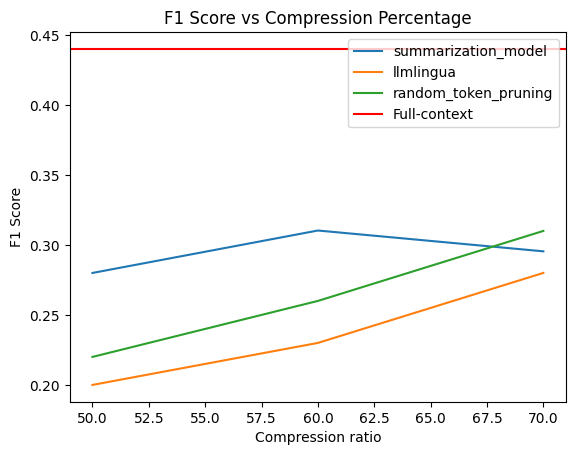

In [5]:
plt.plot(summ_metrics_df['Compression (%)'], summ_metrics_df['F1'], label='summarization_model')
plt.plot(llmlingua_df['Compression (%)'], llmlingua_df['F1'], label='llmlingua')
plt.plot(random_token_pruning_df['Compression (%)'], random_token_pruning_df['F1'], label='random_token_pruning')
plt.axhline(y=no_pruning_data['F1'], color='r', linestyle='-', label='Full-context')
plt.legend()
plt.xlabel('Compression ratio')
plt.ylabel('F1 Score')
plt.title("F1 Score vs Compression Percentage")
plt.show()

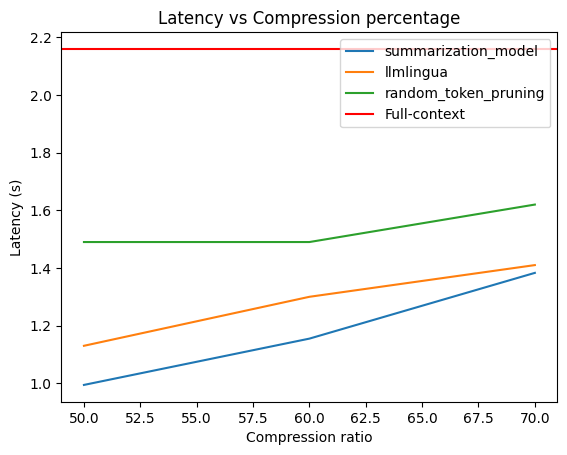

In [6]:
plt.plot(summ_metrics_df['Compression (%)'], summ_metrics_df['Latency (s)'], label='summarization_model')
plt.plot(llmlingua_df['Compression (%)'], llmlingua_df['Latency (s)'], label='llmlingua')
plt.plot(random_token_pruning_df['Compression (%)'], random_token_pruning_df['Latency (s)'], label='random_token_pruning')
plt.axhline(y=no_pruning_data['Latency (s)'], color='r', linestyle='-', label='Full-context')
plt.legend()
plt.xlabel('Compression ratio')
plt.ylabel('Latency (s)')
plt.title("Latency vs Compression percentage")
plt.show()

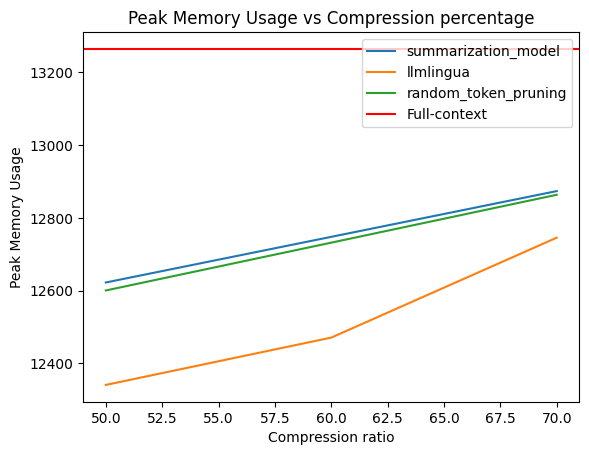

In [7]:
plt.plot(summ_metrics_df['Compression (%)'], summ_metrics_df['Peak Memory (MB)'], label='summarization_model')
plt.plot(llmlingua_df['Compression (%)'], llmlingua_df['Peak Memory (MB)'], label='llmlingua')
plt.plot(random_token_pruning_df['Compression (%)'], random_token_pruning_df['Peak Memory (MB)'], label='random_token_pruning')
plt.axhline(y=no_pruning_data['Peak Memory (MB)'], color='r', linestyle='-', label='Full-context')
plt.legend()
plt.xlabel('Compression ratio')
plt.ylabel('Peak Memory Usage')
plt.title("Peak Memory Usage vs Compression percentage")
plt.show()